# Compressed Representation
A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

Let's get started by importing our libraries and getting the dataset.



# imports and helpers

In [2]:
# ! pip install torch
# ! pip install torchvision
# ! pip inatall matplotlib

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img, ax = None):
    #img = img / 2 + 0.5  # unnormalize
    is_tensor = isinstance(img, torch.Tensor)
    if is_tensor:
        img = img.detach().numpy()

    if ax:
        ax.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
        return
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']



# weights and bias

In [5]:
# import wandb
# #! wandb login
#
# # Initialize a new W&B run
# wandb.init()
# # 50187b18256c8d9e1e0a36d7254f0906c1ba315e

In [6]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Data setup



In [7]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# Visualize the data

In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

hi


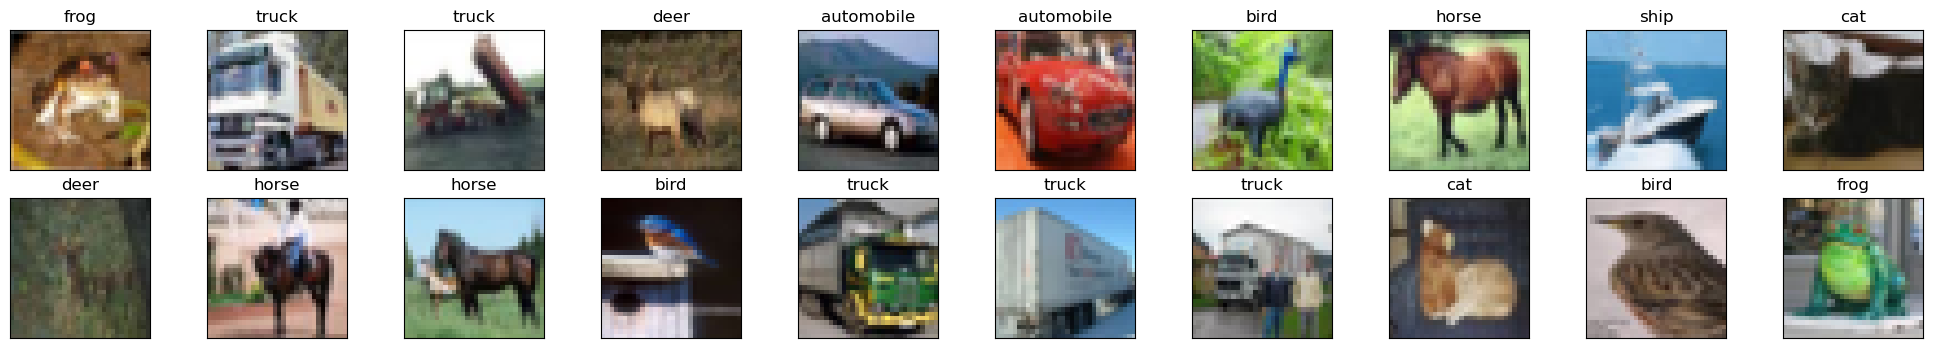

In [417]:
# # obtain one batch of training images
dataiter = iter(train_loader)
testiter = iter(test_loader)

images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
print("hi")
#
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# imshow(images[0])
# plt.show()

# Network architecture

## Convolutional Autoencoder

In [300]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv0 = nn.Conv2d(3, 16, 3, padding=1)
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv1 = nn.Conv2d(16, 4, 3, padding=1)

        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        #self.latent =

        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv0 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv1 = nn.ConvTranspose2d(16, 3, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(3, 3, 3, stride=1,padding=1)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        x = F.relu(self.conv0(x))
        x = self.pool(x)
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        #x = self.pool(x)  # compressed representation

        ## decode ##
        x = F.relu(self.t_conv0(x))
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))


        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv_up0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv_mix0): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv_up1): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
  (t_conv_mix2): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)



# Training
Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards.

We are not concerned with labels in this case, just images, which we can get from the train_loader. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use BCELoss. And compare output images and input images as follows:

## Loss function and optimizer

we will compute the loss as such:
loss = criterion(outputs, images)


In [15]:
# loss function
criterion = nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# we will compute the loss as such
# loss = criterion(outputs, images)


# DataLoader

In [301]:
# # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)

images = images.numpy() # convert images to numpy for display
#
reconstructed_images = model(torch.from_numpy(images)).detach().numpy()
# plot the images in the batch, along with the corresponding labels
print(reconstructed_images.shape)
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
# display 3 images
for i in range(3):
    # Displaying the original image
    imshow(images[i],ax=axs[0, i])
    axs[0, i].axis('off')  # Turn off the axis for a cleaner look

    # Displaying the reconstructed image
    imshow(reconstructed_images[i], ax=axs[1, i])
    axs[1, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow(reconstructed_images[i] - images[i], ax=axs[2, i])
    axs[2, i].axis('off')  # Turn off the axis here as well


plt.tight_layout()
plt.show()

AttributeError: 'ConvAutoencoder' object has no attribute 't_conv0'

## Training loop

In [441]:
def train(model,
          criterion = nn.BCELoss(),
          n_epochs = 10,
          lr=0.001,
          train_loader=train_loader
          ):


    # specify loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # number of epochs to train the model

    for epoch in range(1, n_epochs+1):

        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)

        # print avg training statistics
        train_loss = train_loss/len(train_loader)
        if not epoch % 10:
            torch.save(model, f'model_conv_res_{epoch}.pth')
        torch.save(model, f'model_conv_res_{epoch}.pth')
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch,
            train_loss
        ))
    return model,train_loss
train(model, n_epochs=10000)

KeyboardInterrupt: 

# Convolutional Residual AE

In [290]:
class ConvResidualAutoEncoder(nn.Module):

    def __init__(self,num_passes=4,pt_block = None,latent = ):
        super(ConvResidualAutoEncoder, self).__init__()

        self.num_passes = num_passes
        self.blocks = nn.ModuleList([ConvAutoencoder() for p in range(num_passes)])
        if pt_block:
            #self.blocks = nn.ModuleList([torch.load(pt_block) for p in range(num_passes)])
            self.blocks[0] = torch.load(pt_block)



    def forward(self,x):
        in_x = x.clone()
        residual_outputs = []

        # go through all residuals
        for i, b in enumerate(self.blocks):
            x = b(x)
            # save current approximation
            residual_outputs.append(x.clone())

            if i == self.num_passes -1:
                break
            # subtract the previous
            x = in_x - x

        return x

    def tap_in(self,x):
        in_x = x.clone()
        residual_outputs = []

        # go through all residuals
        for i, b in enumerate(self.blocks):
            x = b(x)
            # save current approximation
            residual_outputs.append(x.clone())

            if i == self.num_passes -1:
                break
            # subtract the previous
            x = in_x - x

        return x, residual_outputs

model = ConvResidualAutoEncoder(num_passes=4)
model.eval()

ConvResidualAutoEncoder(
  (blocks): ModuleList(
    (0-3): 4 x ConvAutoencoder(
      (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (t_conv0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
      (t_conv1): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
      (t_conv2): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [298]:
train(model, n_epochs=100)

Epoch: 1 	Training Loss: 11.179282


KeyboardInterrupt: 

In [222]:
torch.save(model, f'model_conv_res.pth')


In [227]:
model = torch.load(f'model_conv_res.pth')

# visualize the results:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(20, 3, 32, 32)


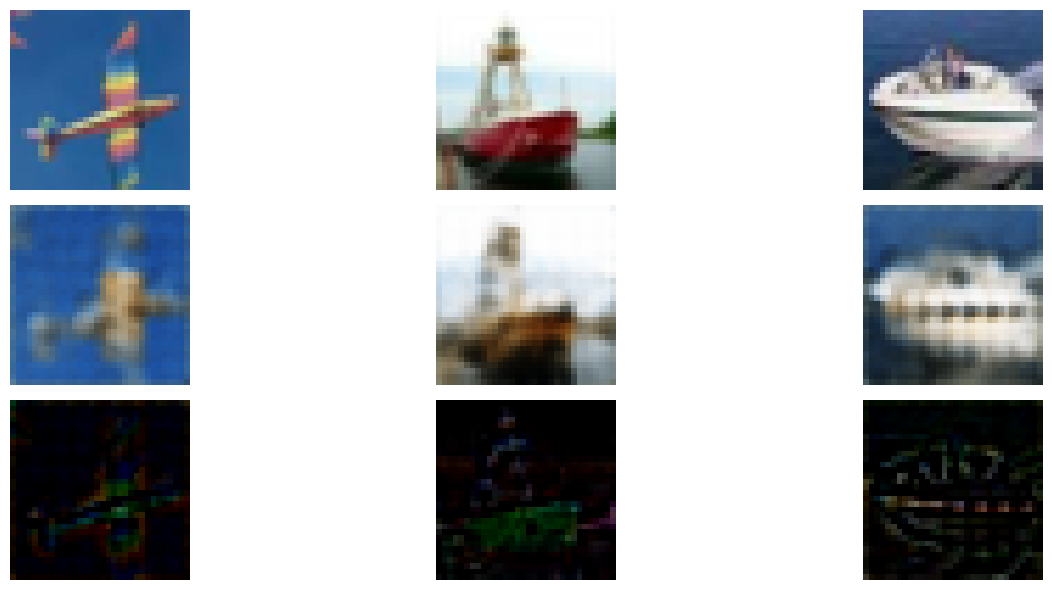

In [286]:
# # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)

images = images.numpy() # convert images to numpy for display
#
reconstructed_images = model(torch.from_numpy(images)).detach().numpy()
# plot the images in the batch, along with the corresponding labels
print(reconstructed_images.shape)
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
# display 3 images
for i in range(3):
    # Displaying the original image
    imshow(images[i],ax=axs[0, i])
    axs[0, i].axis('off')  # Turn off the axis for a cleaner look

    # Displaying the reconstructed image
    imshow(reconstructed_images[i], ax=axs[1, i])
    axs[1, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow(reconstructed_images[i] - images[i], ax=axs[2, i])
    axs[2, i].axis('off')  # Turn off the axis here as well


plt.tight_layout()
plt.show()

torch.Size([20, 3, 32, 32])


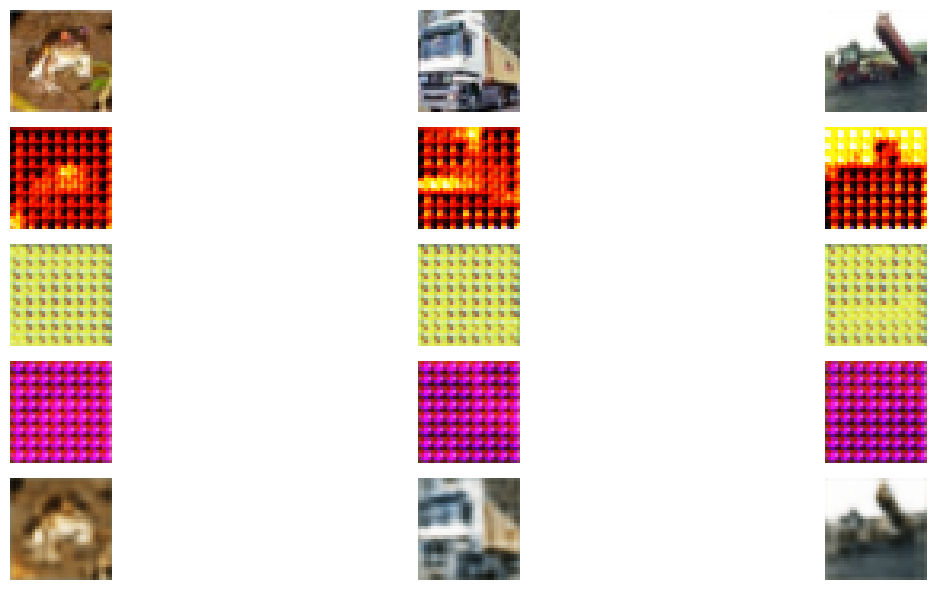

In [299]:
# # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)


images = images.numpy() # convert images to numpy for display
#
reconstructed_images, stages = model.tap_in(torch.from_numpy(images))

# plot the images in the batch, along with the corresponding labels
print(reconstructed_images.shape)
fig, axs = plt.subplots(5, 3, figsize=(15, 6))
# display 3 images
for i in range(3):
    # Displaying the original image
    imshow(images[i],ax=axs[0, i])
    axs[0, i].axis('off')  # Turn off the axis for a cleaner look

    # Displaying the reconstructed image
    imshow(stages[0][i], ax=axs[1, i])
    axs[1, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow(stages[1][i], ax=axs[2, i])
    axs[2, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow(stages[2][i], ax=axs[3, i])
    axs[3, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow(stages[3][i], ax=axs[4, i])
    axs[4, i].axis('off')  # Turn off the axis here as well

plt.tight_layout()
plt.show()

# Let's try starting with a pretrained AE

In [292]:
model = ConvResidualAutoEncoder(num_passes=4,pt_block='model_conv.pth')

# next attempt: limiting the latent

In [331]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder2, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv0 = nn.Conv2d(3, 16, 3, padding=1)
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv1 = nn.Conv2d(16, 16, 3, padding=1)

        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)

        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        #self.latent =

        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv_up0 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv_mix0 = nn.ConvTranspose2d(16, 16, 3, stride=1,padding=1)
        self.t_conv_up1 = nn.ConvTranspose2d(16, 3, 2, stride=2)
        self.t_conv_mix1 = nn.ConvTranspose2d(3, 3, 3, stride=1,padding=1)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        x = F.relu(self.conv0(x))
        x = self.pool(x)
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add second hidden layer
        #x = self.pool(x)  # compressed representation

        ## decode ##
        x = F.relu(self.t_conv_up0(x))
        x = F.sigmoid(self.t_conv_mix0(x))
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv_up1(x))
        x = F.sigmoid(self.t_conv_mix1(x))
        # output layer (with sigmoid for scaling from 0 to 1)


        return x

# initialize the NN
model = ConvAutoencoder2()
print(model)

ConvAutoencoder2(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv_up0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv_mix0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv_up1): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
  (t_conv_mix1): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [420]:
class ConvResidualAutoEncoder2(nn.Module):

    def __init__(self,num_passes=4,pt_block = None):
        super(ConvResidualAutoEncoder2, self).__init__()

        self.num_passes = num_passes
        self.blocks = nn.ModuleList([ConvAutoencoder2() for p in range(num_passes)])
        if pt_block:
            #self.blocks = nn.ModuleList([torch.load(pt_block) for p in range(num_passes)])
            self.blocks[0] = torch.load(pt_block)



    def forward(self,x):
        in_x = x.clone()
        residual_outputs = []

        # go through all residuals
        for i, b in enumerate(self.blocks):
            x = b(x)
            # save current approximation
            residual_outputs.append(x.clone())

            if i == self.num_passes -1:
                break
            # subtract the previous
            x = in_x - x

        return (1/self.num_passes)*(sum(residual_outputs))

    def tap_in(self,x):
        in_x = x.clone()
        residual_outputs = []

        # go through all residuals
        for i, b in enumerate(self.blocks):
            x = b(x)
            # save current approximation
            residual_outputs.append(x.clone())

            if i == self.num_passes -1:
                break
            # subtract the previous
            x = in_x - x

        return (1/self.num_passes)*(sum(residual_outputs)), residual_outputs

model = ConvResidualAutoEncoder2(num_passes=4)
model.eval()

ConvResidualAutoEncoder2(
  (blocks): ModuleList(
    (0-3): 4 x ConvAutoencoder2(
      (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (t_conv_up0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
      (t_conv_mix0): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (t_conv_up1): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
      (t_conv_mix1): ConvTranspose2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

torch.Size([20, 3, 32, 32])


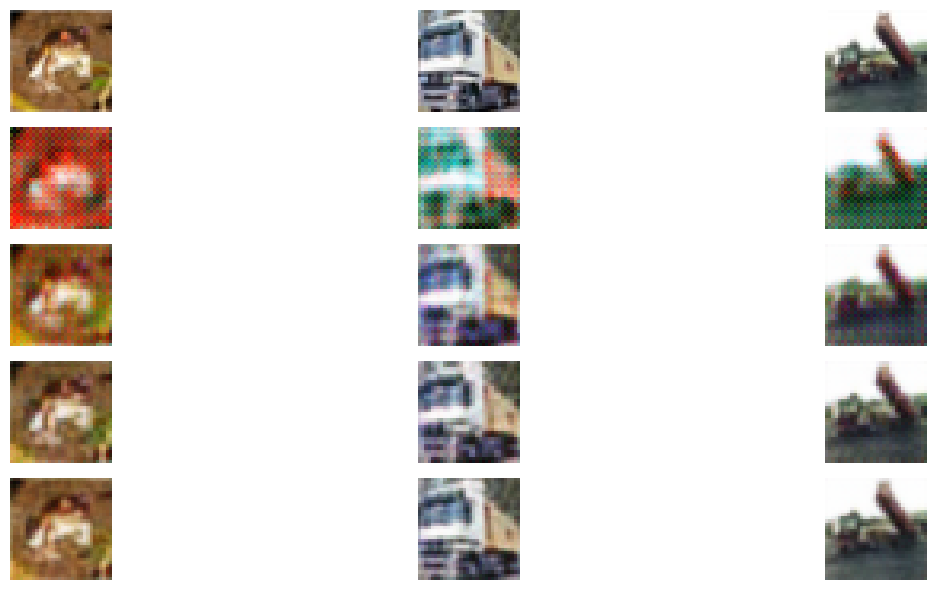

In [439]:
# # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
#images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(dataiter)
# images, labels = next(testiter)
# images, labels = next(testiter)
# images, labels = next(testiter)


images = images.numpy() # convert images to numpy for display
#
reconstructed_images, stages = model.tap_in(torch.from_numpy(images))

# plot the images in the batch, along with the corresponding labels
print(reconstructed_images.shape)
fig, axs = plt.subplots(5, 3, figsize=(15, 6))
# display 3 images
for i in range(3):
    # Displaying the original image
    imshow(images[i],ax=axs[0, i])
    axs[0, i].axis('off')  # Turn off the axis for a cleaner look

    # Displaying the reconstructed image
    imshow(stages[0][i], ax=axs[1, i])
    axs[1, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow((1/2)*(stages[1][i]+stages[0][i]), ax=axs[2, i])
    axs[2, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow((1/3)*(stages[2][i]+stages[1][i]+stages[0][i]), ax=axs[3, i])
    axs[3, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow((1/4)*(stages[3][i]+stages[2][i]+stages[1][i]+stages[0][i]), ax=axs[4, i])
    axs[4, i].axis('off')  # Turn off the axis here as well

plt.tight_layout()
plt.show()

In [ ]:
train(model,n_epochs=1000)

Epoch: 1 	Training Loss: 11.031990
Epoch: 2 	Training Loss: 11.031176
Epoch: 3 	Training Loss: 11.030451
Epoch: 4 	Training Loss: 11.029795
Epoch: 5 	Training Loss: 11.029136
Epoch: 6 	Training Loss: 11.028498
Epoch: 7 	Training Loss: 11.027897
Epoch: 8 	Training Loss: 11.027313
Epoch: 9 	Training Loss: 11.026758
Epoch: 10 	Training Loss: 11.026236
Epoch: 11 	Training Loss: 11.025775
Epoch: 12 	Training Loss: 11.025308
Epoch: 13 	Training Loss: 11.024853
Epoch: 14 	Training Loss: 11.024437
Epoch: 15 	Training Loss: 11.023990
Epoch: 16 	Training Loss: 11.023626
Epoch: 17 	Training Loss: 11.023266
Epoch: 18 	Training Loss: 11.022911
Epoch: 19 	Training Loss: 11.022543
Epoch: 20 	Training Loss: 11.022212
Epoch: 21 	Training Loss: 11.021911
Epoch: 22 	Training Loss: 11.021574
Epoch: 23 	Training Loss: 11.021276
Epoch: 24 	Training Loss: 11.021037
Epoch: 25 	Training Loss: 11.020709
Epoch: 26 	Training Loss: 11.020450


In [416]:
torch.save(model, f'model_fc.pth')